In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dropout,Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [2]:
#root_dir = "/kaggle/input/6-7-8/procedure-6"
root_dir = "/kaggle/input/6-7-8/procedure-7"
#root_dir = "/kaggle/input/6-7-8/procedure-8"


train_dir = root_dir + "/train"
val_dir = root_dir + "/val"
test_dir = root_dir + "/test"

In [3]:
#WORK_DIR = './dataset/'

CLASSES = [ 'AD', 'CN']

IMG_SIZE = 160
DIM = (IMG_SIZE, IMG_SIZE)

featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False

In [4]:
datagen = IDG(rescale = 1./255) 

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='binary',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=val_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='binary',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=200,
                                             class_mode='binary')

Found 7824 images belonging to 2 classes.
Found 1728 images belonging to 2 classes.
Found 1680 images belonging to 2 classes.


--------

plot_training_metrics function will be provided most needed result metrics. If you want to adjust and more, feel free to improve.

In [5]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results: 
    #. test_metrics[0] = loss, 
    #  test_metrics[1] = auc, 
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [6]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred

----

# MODELS #

## FEATURE EXTRACTION USING CNN AND TRAIN ON SVM - RF

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [8]:
model.compile(optimizer='adam',
loss=tensorflow.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=10)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/10
62/62 [==============================] - 48s 643ms/step - loss: 0.6803 - auc: 0.5433 - acc: 0.5812 - val_loss: 0.7308 - val_auc: 0.6036 - val_acc: 0.5405
Epoch 2/10
62/62 [==============================] - 21s 337ms/step - loss: 0.6419 - auc: 0.6623 - acc: 0.6332 - val_loss: 0.6399 - val_auc: 0.6743 - val_acc: 0.6302
Epoch 3/10
62/62 [==============================] - 20s 321ms/step - loss: 0.5900 - auc: 0.7437 - acc: 0.6929 - val_loss: 0.6514 - val_auc: 0.6891 - val_acc: 0.6076
Epoch 4/10
62/62 [==============================] - 20s 320ms/step - loss: 0.5586 - auc: 0.7768 - acc: 0.7161 - val_loss: 0.6782 - val_auc: 0.6779 - val_acc: 0.6100
Epoch 5/10
62/62 [==============================] - 20s 326ms/step - loss: 0.5209 - auc: 0.8126 - acc: 0.7408 - val_loss: 0.6642 - val_auc: 0.6832 - val_acc: 0.6372
Epoch 6/10
62/62 [==============================] - 20s 317ms/step - loss: 0.4809 - auc: 0.8451 - acc: 0.7707 - val_loss: 0.7804 - val_auc: 0.6791 - val_acc: 0.6198
Epoch 7/10

In [9]:
train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=7900,
                                             class_mode='binary',
                                             shuffle=True)

Found 7824 images belonging to 2 classes.


In [12]:
x_train, y_train = train_gen.next()

In [13]:
# Create a new model with the desired intermediate layer as output
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from your data using the feature_extractor
train_features = feature_extractor.predict(x_train)

# Reshape the features to match the expected input shape for random forest
train_features_reshaped = np.reshape(train_features, (len(train_features), -1))

# Prepare the labels for random forest
train_labels = np.array(y_train)

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier on the extracted features and labels
rf_classifier.fit(train_features_reshaped, train_labels)

RandomForestClassifier()

In [18]:
test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=3000,
                                             class_mode='binary')

Found 1680 images belonging to 2 classes.


In [19]:
x_test, y_test = test_gen.next()

In [20]:
# Extract features from the new data using the feature_extractor
new_data_features = feature_extractor.predict(x_test)

# Reshape the new data features
new_data_features_reshaped = np.reshape(new_data_features, (len(new_data_features), -1))

# Make predictions using the random forest classifier
results = rf_classifier.predict(new_data_features_reshaped)

In [21]:
print(classification_report(y_test, results, target_names=["AD", "CN"]))

              precision    recall  f1-score   support

          AD       0.59      0.63      0.61       720
          CN       0.71      0.66      0.68       960

    accuracy                           0.65      1680
   macro avg       0.65      0.65      0.65      1680
weighted avg       0.65      0.65      0.65      1680




 Model AUC 71.95%, Accuracy 65.60% on Test Data

              precision    recall  f1-score   support

          AD       0.59      0.63      0.61       720
          CN       0.71      0.66      0.68       960

    accuracy                           0.65      1680
   macro avg       0.65      0.65      0.65      1680
weighted avg       0.65      0.65      0.65      1680



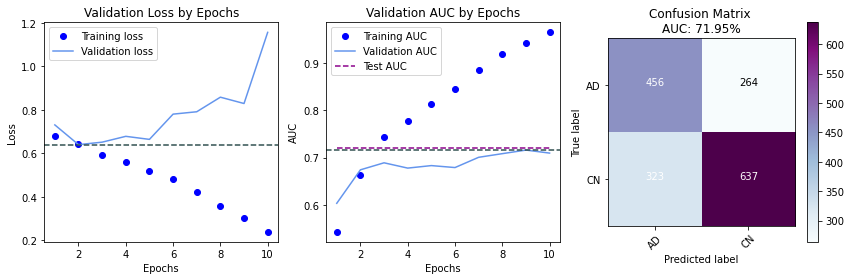

In [25]:
y_pred = tensorflow.cast(tensorflow.round(results), tensorflow.int32).numpy().flatten()
y_true = y_test
plot_training_metrics(history, model, test_gen, y_true, y_pred, ['AD','CN'], model_name = "customCNN")

_____

## VGG19

In [8]:
vgg = VGG19(input_shape=(160,160,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [9]:
model.compile(optimizer='adam',
loss=tensorflow.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])

tic = time.perf_counter()
history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=1)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

62/62 [==============================] - 33s 407ms/step - loss: 0.6496 - auc: 0.6527 - acc: 0.6348 - val_loss: 0.6215 - val_auc: 0.6974 - val_acc: 0.6551
Total Time:0.7


In [ ]:
def step(inputs):
    data, label = inputs 
    outputs = model.predict(data)
    preds = tensorflow.cast(tensorflow.round(outputs), tensorflow.int32).numpy().flatten()
    return preds, outputs

prediction_list = []
def predict(dataloader):
    for i, batch in enumerate(dataloader):
        pred, output = step(batch)
        prediction_list.append(pred.cpu())

In [ ]:
#y_true, y_pred = prepare_for_test(model, test_gen)
#for binary classification
data, y_true = test_gen.next()
y_pred = []
y_pred = model.predict(data, 10)
y_pred = tensorflow.cast(tensorflow.round(y_pred), tensorflow.int32).numpy().flatten()
plot_training_metrics(history, model, test_gen, y_true, y_pred, ['AD','CN'], model_name = "vgg19_procedure7")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_vgg19_model"
#model.save(model_dir, save_format='h5')
#np.save('my_vgg19_history.npy', history.history)
#history=np.load('my_vgg19_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

-----

## VGG16

In [ ]:
vgg = VGG16(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)
tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg16")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_vgg16_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg16_history.npy', history.history)
#history=np.load('my_vgg16_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## ResNet50

In [ ]:
rn = ResNet50(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet50")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_resnet50_model"
model.save(model_dir, save_format='h5')
np.save('my_resnet50_history.npy', history.history)
#history=np.load('my_resnet50_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## ResNet 101

In [ ]:
rn = ResNet101(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=20)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
#y_true, y_pred = prepare_for_test(model, test_gen)
#for binary classification
data, y_true = test_gen.next()
y_pred = []
y_pred = model.predict(data, 200)
y_pred = tensorflow.cast(tensorflow.round(y_pred), tensorflow.int32).numpy().flatten()
plot_training_metrics(history, model, test_gen, y_true, y_pred, ['AD','CN'], model_name = "resnet101")

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet101")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_resnet101_model"
model.save(model_dir, save_format='h5')
np.save('my_resnet101_history.npy', history.history)
#history=np.load('my_resnet101_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## Xception

In [ ]:
model = Xception(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])


tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=20)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
#y_true, y_pred = prepare_for_test(model, test_gen)
#for binary classification
data, y_true = test_gen.next()
y_pred = []
y_pred = model.predict(data, 200)
y_pred = tensorflow.cast(tensorflow.round(y_pred), tensorflow.int32).numpy().flatten()
plot_training_metrics(history, model, test_gen, y_true, y_pred, ['AD','CN'], model_name = "inceptionv3")

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['AD', 'CN'], model_name = "xception")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_xception_model"
#model.save(model_dir, save_format='h5')
#np.save('my_xception_history.npy', history.history)
#history=np.load('my_xception_history.npy',allow_pickle='TRUE').item()
#premodel = tensorflow.keras.models.load_model(model_dir)

----

## MobileNet

In [ ]:
model = MobileNet(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "mobilenet")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_mobilenet_model"
model.save(model_dir, save_format='h5')
np.save('my_mobilenet_history.npy', history.history)
#history=np.load('my_mobilenet_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## MobileNetV2

In [ ]:
model = MobileNetV2(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "mobilenetv2")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_mobilenetv2_model"
model.save(model_dir, save_format='h5')
np.save('my_mobilenetv2_history.npy', history.history)
#history=np.load('my_mobilenetv2_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

-----

## DenseNet169

In [ ]:
model = DenseNet169(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet169")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_densenet169_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet169_history.npy', history.history)
#history=np.load('my_densenet169_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## DenseNet121

In [ ]:
model = DenseNet121(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

In [ ]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet121")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_densenet121_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet121_history.npy', history.history)
#history=np.load('my_densenet121_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## InceptionV3

In [21]:
model = InceptionV3(input_shape=(160,160,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])


tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/50
38/38 [==============================] - 19s 371ms/step - loss: 4.7375 - auc: 0.5409 - acc: 0.3712 - val_loss: 2.3275 - val_auc: 0.5501 - val_acc: 0.3678
Epoch 2/50
38/38 [==============================] - 12s 323ms/step - loss: 1.6049 - auc: 0.6430 - acc: 0.4561 - val_loss: 1.6452 - val_auc: 0.5752 - val_acc: 0.3994
Epoch 3/50
38/38 [==============================] - 12s 318ms/step - loss: 1.1077 - auc: 0.7138 - acc: 0.5241 - val_loss: 1.3985 - val_auc: 0.5804 - val_acc: 0.3985
Epoch 4/50
38/38 [==============================] - 12s 313ms/step - loss: 1.1055 - auc: 0.7270 - acc: 0.5418 - val_loss: 1.6366 - val_auc: 0.5960 - val_acc: 0.4215
Epoch 5/50
38/38 [==============================] - 12s 316ms/step - loss: 0.9132 - auc: 0.7847 - acc: 0.5968 - val_loss: 1.5623 - val_auc: 0.5572 - val_acc: 0.3755
Epoch 6/50
38/38 [==============================] - 12s 324ms/step - loss: 0.8493 - auc: 0.8119 - acc: 0.6303 


 Model AUC 57.75%, Accuracy 40.94% on Test Data

              precision    recall  f1-score   support

          AD       0.39      0.39      0.39       270
          CN       0.44      0.52      0.47       360
         MCI       0.39      0.32      0.35       396

    accuracy                           0.41      1026
   macro avg       0.41      0.41      0.41      1026
weighted avg       0.41      0.41      0.41      1026



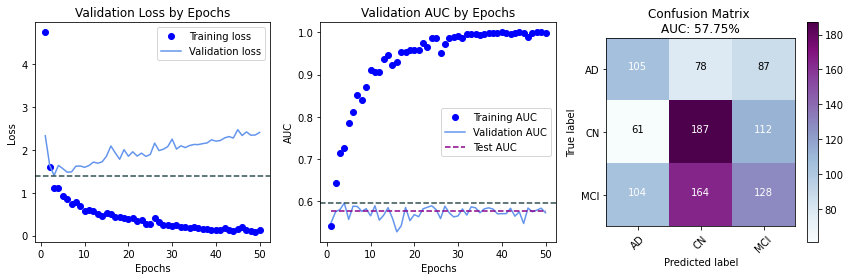

In [22]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen, y_true, y_pred, ['AD', 'CN'], model_name = "inceptionv3_procedure7")

In [ ]:
# SAVE MODEL
model_dir = "./alzheimer_inceptionv3_model"
model.save(model_dir, save_format='h5')
np.save('my_inceptionv3_history.npy', history.history)
#history=np.load('my_inceptionv3_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)